In [40]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def load_npy_image(file_path):
    """Load a .npy image file."""
    try:
        return np.load(file_path)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None  # Return None if loading fails

def resize_image(image, size=(224, 224)):
    """Resize an image to a given size."""
    resized_image = tf.image.resize(image, size)
    return resized_image.numpy()  # Convert to NumPy array after resizing

def normalize_image(image):
    """Normalize image values to range [0, 1]."""
    if image is not None:
        return image.astype(np.float32) / 255.0  # Normalize to [0, 1]
    return None

def load_and_preprocess_images(data_dir, num_samples=5):
    """Load and preprocess images for the inpainting task."""
    masked_files = sorted(
        [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith("masked_")]
    )
    
    images = []
    for i, file_path in enumerate(masked_files[:num_samples]):
        img = load_npy_image(file_path)
        print(img.shape)
        if img is not None:
            img = resize_image(img)
            img = normalize_image(img)
            images.append(img)
            # Check dimensions for compatibility
            check_image_dimensions(img)
        else:
            print(f"Skipping {file_path} due to loading error.")

    return images

def check_image_dimensions(image):
    """Check if the image has the correct dimensions."""
    if image.ndim != 3 or image.shape[-1] != 3:
        raise ValueError(f"Image dimensions are not compatible: {image.shape}. Expected shape: [height, width, 3]")

def display_images(images):
    """Display images in a grid."""
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


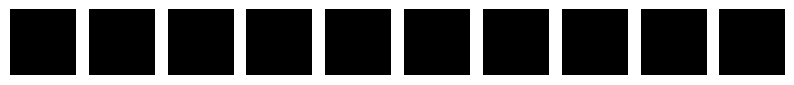

In [4]:
data_dir = r"F:\ssl_images\data\processed\coco\inpainting"  # Use raw string
images = load_and_preprocess_images(data_dir, 10)
display_images(images)


In [38]:
import tensorflow as tf
a = tf.io.read_file(r"F:\ssl_images\data\processed\coco\inpainting\masked_0.npy")


In [39]:
type(a)

tensorflow.python.framework.ops.EagerTensor

In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import tensorflow as tf
from tqdm import tqdm
import sys

#sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), "..")))
from src.models.resnet import ResNet18

def load_and_preprocess_image(image_path):
    """Load and preprocess a single image for colorization."""
    # Load image
    img = np.load(image_path)
    
    # Convert to float and normalize
    img = tf.cast(img, tf.float32) / 255.0
    
    # Ensure grayscale input
    if len(img.shape) == 3 and img.shape[-1] == 3:
        img = tf.image.rgb_to_grayscale(img)
    
    # Add batch dimension
    img = tf.expand_dims(img, 0)
    
    return img

def visualize_colorization(model_path, image_path):
    """Load model, process image, and visualize results."""
    # Initialize model
    model = ResNet18((224, 224, 1))
    
    # Load trained weights
    model.load_weights(model_path)
    
    # Load and preprocess input image
    input_image = load_and_preprocess_image(image_path)
    
    # Get model prediction
    predicted_color = model.predict(input_image)
    
    # Remove batch dimension
    input_image = tf.squeeze(input_image)
    predicted_color = tf.squeeze(predicted_color) * 255.0
    
    # Load original color image for comparison
    color_path = image_path.replace('gray', 'color')
    original_color = np.load(color_path)
    original_color = original_color.astype(np.float32) #/ 255.0
    
    # Create figure with three subplots
    plt.figure(figsize=(15, 5))
    
    # Plot grayscale input
    plt.subplot(1, 3, 1)
    plt.imshow(input_image, cmap='gray')
    plt.title('Grayscale Input')
    plt.axis('off')
    
    # Plot model prediction
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_color)
    plt.title('Model Colorization')
    plt.axis('off')
    
    # Plot original color image
    plt.subplot(1, 3, 3)
    plt.imshow(original_color)
    plt.title('Original Color')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    mae = tf.reduce_mean(tf.abs(original_color - predicted_color))
    print(f"Mean Absolute Error: {mae:.4f}")


F:\ssl_images\data\processed\coco\colorization\gray_785.npy
Running colorization inference...
1/1 [==============================] - 1s 566ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


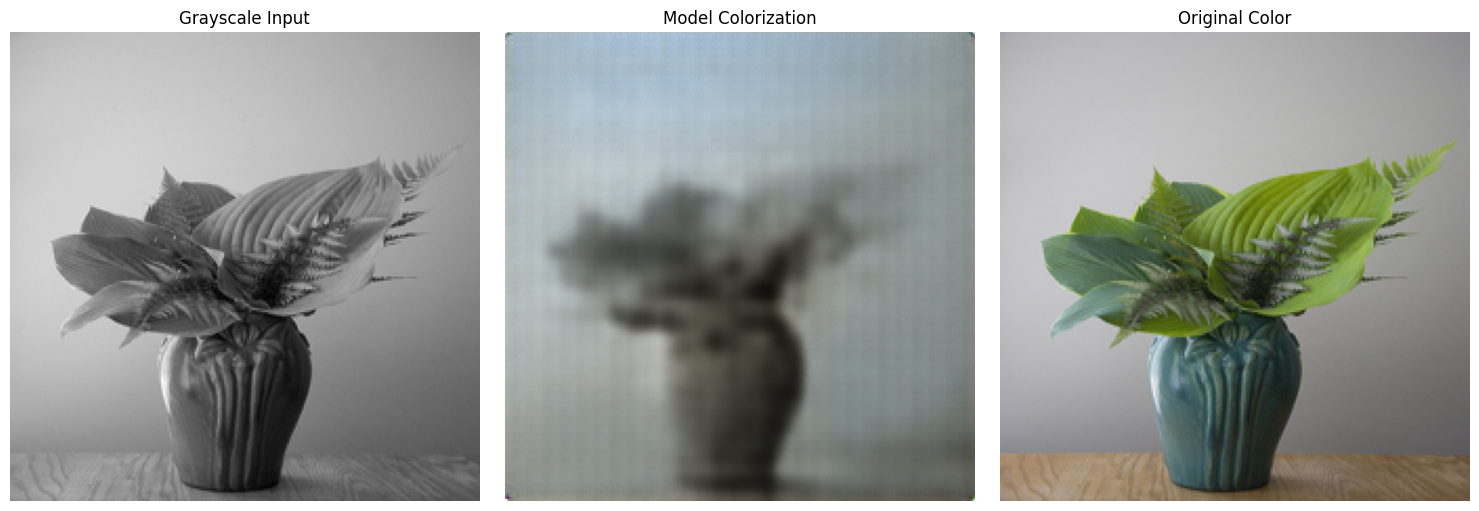

Mean Absolute Error: 0.0575
Visualization complete!


In [21]:
# Set up paths
model_path = os.path.join("models", "colorization_model_final.h5")
data_dir = os.path.join("F:\\ssl_images\\data", "processed", "coco", 'colorization')

# Get a test image path (using the first grayscale image in the directory)
test_image = next(
    os.path.join(data_dir, f) 
    for f in os.listdir(data_dir) 
    if f.startswith("gray")
)
test_image = test_image.replace('_0', '_785')
print(test_image)

print("Running colorization inference...")
visualize_colorization(model_path, test_image)
print("Visualization complete!")